In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline


import warnings
warnings. filterwarnings('ignore')

from sklearn.utils import resample

#import models
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [3]:
train_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


# Feature Engineering

In [5]:
def engineer_features(df):
    df['Stage_fear'] = df['Stage_fear'].fillna(
    pd.Series(
        np.where(df['Post_frequency'] > 5, 'No', 'Yes'),
        index=df.index)
            )

    #drop null rows
    df.dropna(inplace = True)

    df['Stage_fear'] = (df['Stage_fear'] == 'Yes').astype(int)
    df['Drained_after_socializing'] = (df['Drained_after_socializing'] == 'Yes').astype(int)
    
    df['is_social_media_active'] = (df['Post_frequency'] > 5).astype(int)

    df = df.reset_index(drop=True)

    return df

In [6]:
train_df = engineer_features(train_df)

In [7]:
map_target = {'Extrovert' : 1, 'Introvert' : 0}

train_df['Personality'] = train_df['Personality'].replace(map_target)

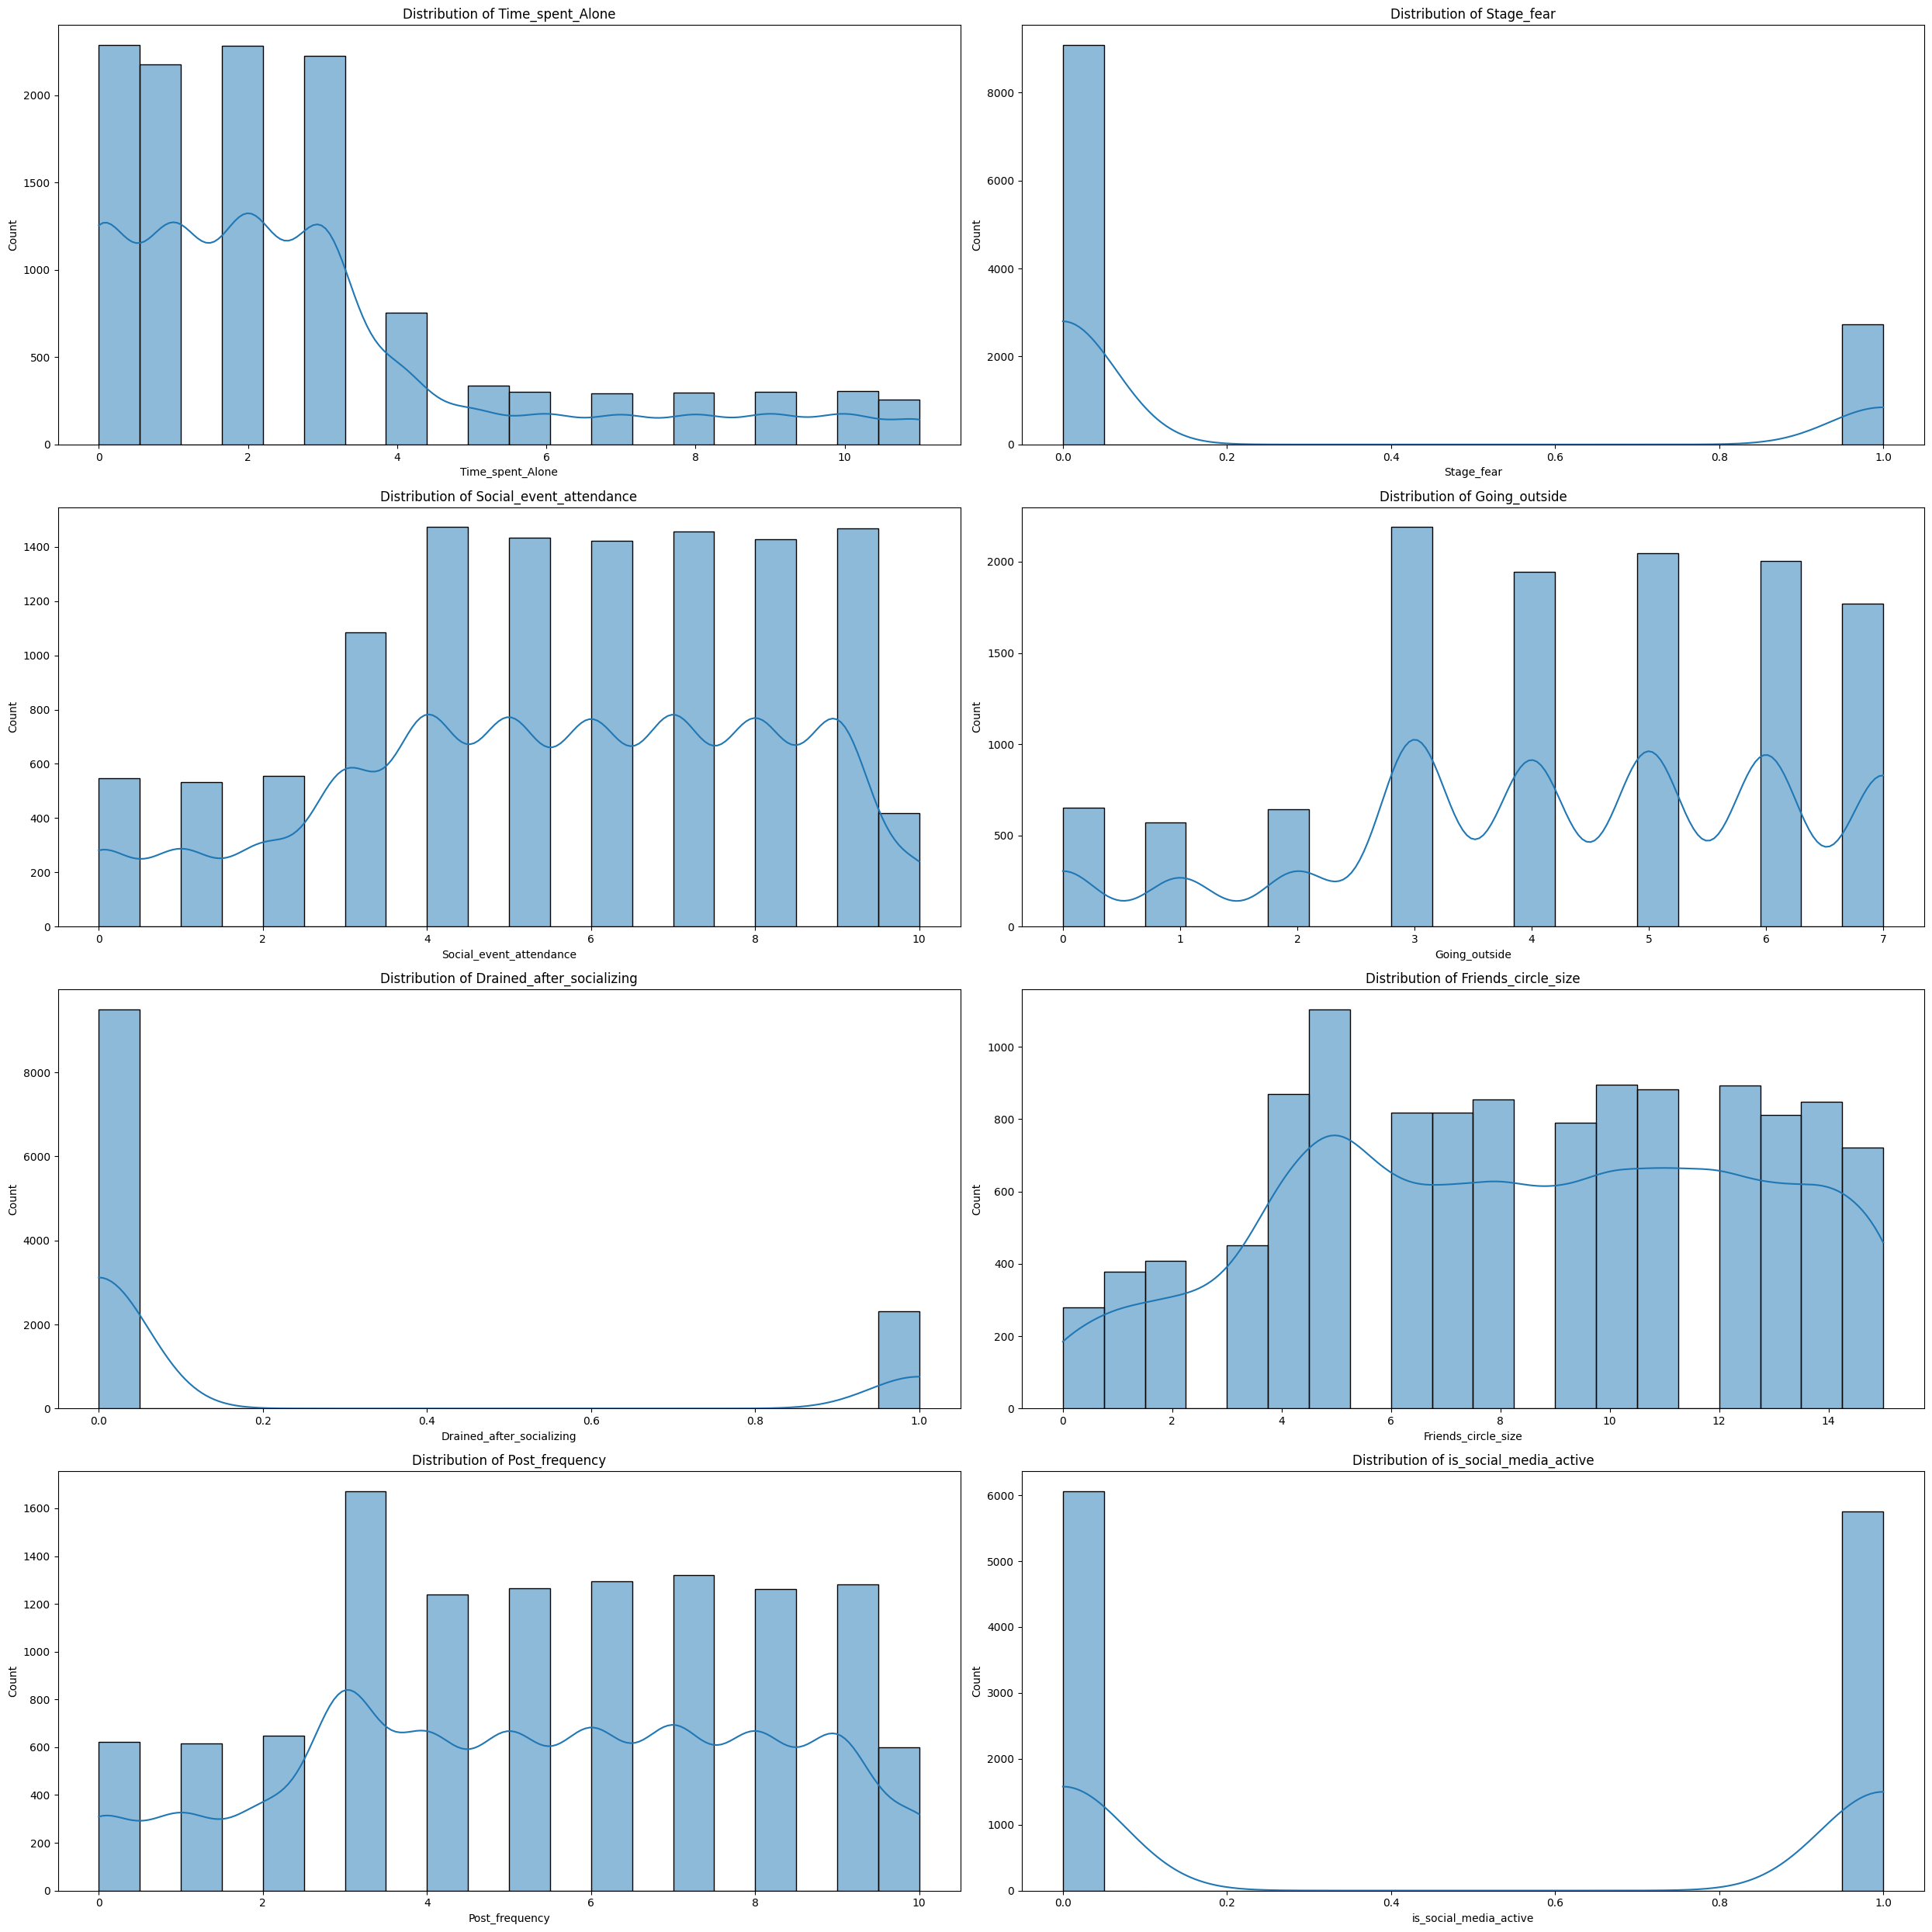

In [8]:
cols = train_df.drop(['Personality','id'], axis=1).columns

# set rows and cols
n_rows = (len(cols) + 1) // 2   # adjust rows to fit all features
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))

# flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(cols):
    sb.histplot(train_df[col], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# remove any empty axes (if number of features not multiple of 2)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


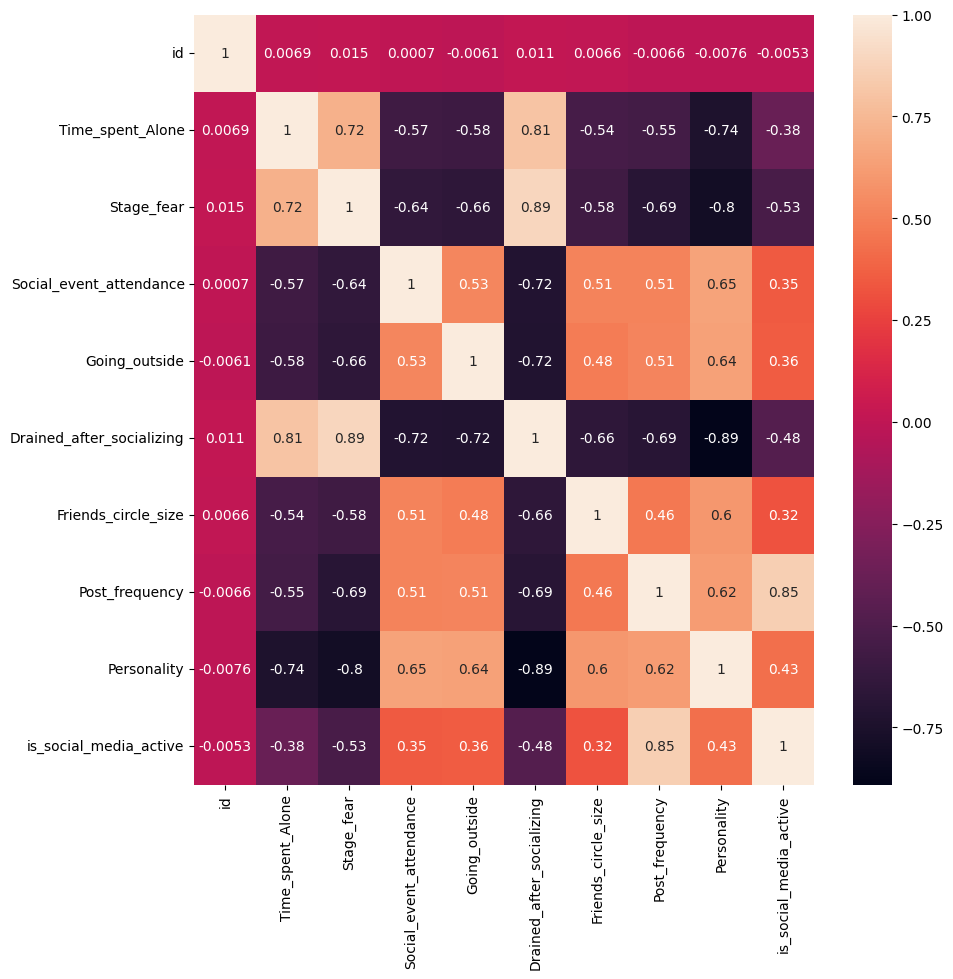

In [9]:
plt.figure(figsize = (10,10))
sb.heatmap(train_df.corr(),annot = True);

In [10]:
train_df['Personality'].value_counts()

Personality
1    9435
0    2384
Name: count, dtype: int64

In [11]:
#choose class size

class_size = 6000 

In [12]:
extrovert = train_df[train_df['Personality'] == 1]
introvert = train_df[train_df['Personality'] == 0]

In [13]:
downsampled_ = resample(extrovert,
                          replace = False,
                          n_samples = class_size,
                          random_state = 27)


upsampled_ = resample(introvert,
                              replace = True,  #sample with replacement(we want to duplicate observation)
                              n_samples = class_size,
                              random_state = 27)


# Combine both to get a balanced dataset
balanced_df = pd.concat([downsampled_, upsampled_])

In [14]:
balanced_df = balanced_df.sort_values(by = 'id')

In [15]:
X = train_df.drop('Personality', axis = 1)
y = train_df['Personality']

# Modelling

In [16]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [17]:
X_train,X_val,y_train, y_val = train_test_split(X_scaled,y, test_size = 0.2, random_state = 42)

In [18]:
rf= RandomForestClassifier()
rf.fit(X_train, y_train)

rf_model = rf.predict(X_val)

In [19]:
xg = XGBClassifier()
xg.fit(X_train,y_train)

xg_model = xg.predict(X_val)

In [20]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

lr_model = lr.predict(X_val)

In [21]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_model = lgbm.predict(X_val)

[LightGBM] [Info] Number of positive: 7544, number of negative: 1911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 9455, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.797885 -> initscore=1.373126
[LightGBM] [Info] Start training from score 1.373126


In [22]:
accuracy_score(y_val, lgbm_model)

0.9640439932318104

# Submission

In [23]:
test_df = engineer_features(test_df)

In [24]:
X_test_scaled = sc.transform(test_df)

In [25]:
final_model = lgbm.predict(X_test_scaled)

In [26]:
test_df['Personality'] = final_model

In [27]:
submission_df = test_df[['id','Personality']]

In [28]:
remap_target = {1 : 'Extrovert', 0 : 'Introvert'}
submission_df['Personality'] = submission_df['Personality'].replace(remap_target)

In [29]:
submission_df.to_csv('submission.csv', index=False)